In [24]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
import numpy as np
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from scipy.linalg import sqrtm

from sklearn.model_selection import train_test_split



digits = datasets.load_digits()
target = digits.target

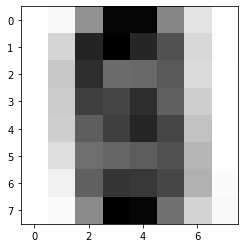

In [25]:
#(a) Plot a picture of the mean vector.
mean = sum(digits.images)/digits.images.shape[0]
plt.imshow(mean, cmap=plt.cm.gray_r)
plt.show()

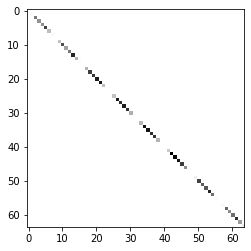

In [26]:
#(c) Plot a picture of the diagonal elements of noise variance.
mu = mean.flatten()
N = digits.images.shape[0]
D = digits.images.shape[1]*digits.images.shape[2]
H = 2

Images = np.zeros((D, N))
for i in range(N):
    Images[:, i] = digits.images[i].flatten() - mu

Var = np.zeros(D)
for i in range(D):
    Var[i] = np.var(Images[i, :])
    if Var[i] == 0:
        Var[i] = 0.01


#initalize diagonal elements of noise variance
Psi = np.diag(Var)
plt.imshow(Psi, cmap=plt.cm.gray_r)
plt.show()

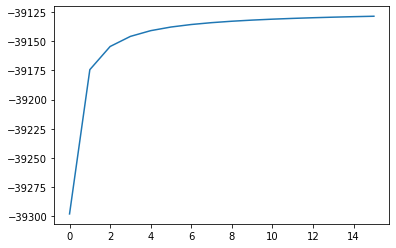

In [27]:
#(d)Plot the trajectory of the average log likelihood for each step until convergence or termination
#for the best parameter


def Scale_X(X, Psi):
    return np.dot(np.linalg.pinv(sqrtm(Psi)), X)/ np.sqrt(N)

do_svd = lambda x: np.linalg.svd(x)

def Llikelihood(Psi, X):
    X = Scale_X(X, Psi)
    U, A, W = do_svd(X)
    A = np.diag(A)
    A = np.dot(A, A)
    U_h = U[:, 0:H]
    A_h = np.diag(np.diag(A)[0:H])
    F = np.dot(np.dot(sqrtm(Psi), U_h), sqrtm(A_h - np.identity(H)))
    ll = -X.shape[1] / 2 * (sum(np.log(np.diag(A)[0:H])) + H + sum(np.diag(A)[H + 1:D]) + np.log(np.linalg.det(2 * np.pi * Psi)))
    return ll, F

def DoIteration(Psi, X):
    l = []
    l_old = 0
    l_new = 500

    # using the algorithm 12.41
    while abs((l_new - l_old) / l_new) > 0.00001:
        l_old = l_new
        l_new, F = Llikelihood(Psi, train_set)
        l.append(l_new.real)
        Psi = np.diag(Var) - np.diag(np.diag(np.dot(F, F.T)))
    return l, F, Psi

def SplitData(X, target, size):
    Index = np.arange(0,N)
    train_in, test_in = train_test_split(Index, test_size=size, random_state=42)
    train = Images[:, train_in]
    test = Images[:, test_in]
    target_train = target[train_in]
    target_test = target[test_in]
    return train, test, target_train, target_test

train_set, test_set, target_train, target_test = SplitData(Images, target, 0.8)
l, F, Psi = DoIteration(Psi, train_set)
plt.plot(l)
plt.show()

In [28]:
#(e) Calculate the average log likelihood the data
ll_train, F = Llikelihood(Psi, train_set)
ll_test, F = Llikelihood(Psi, test_set)
print("Training set :", ll_train)
print("Testing set :", ll_test)


Training set : -39128.482178984996
Testing set : -174215.78150517802


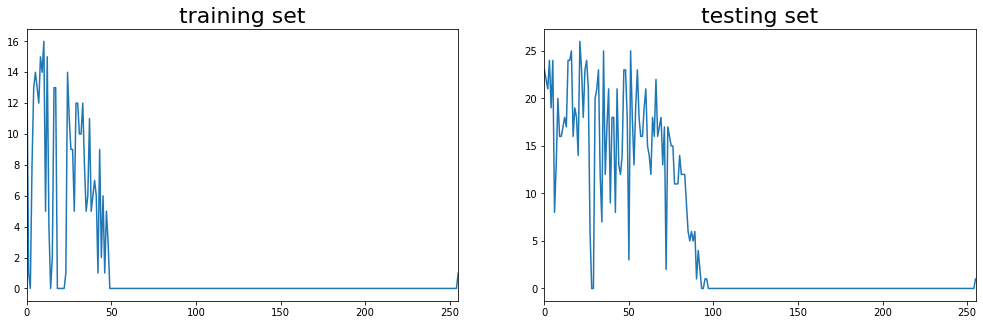

In [30]:
#(f) Histogram of the log likelihoods of the training case and test case

def Llikelihood_list(Psi, X):
    ll_list = []
    X = Scale_X(X, Psi)
    X_temp = np.zeros(X.shape)
    for i in range(X.shape[1]):
        X_temp[:, i] = X[:, i]
        U, A, W = do_svd(X_temp)
        A = np.diag(A)
        A = np.dot(A, A)
        U_h = U[:, 0:H]
        A_h = np.diag(np.diag(A)[0:H])
        F = np.dot(np.dot(sqrtm(Psi), U_h), sqrtm(A_h - np.identity(H)))
        ll = -1 / 2 * (sum(np.log(np.diag(A)[0:H])) + H + sum(np.diag(A)[H + 1:D]) + np.log(np.linalg.det(2 * np.pi * Psi)))
        ll_list.append(ll)
    return ll_list

l_list_train = Llikelihood_list(Psi, train_set)

l_list_test = Llikelihood_list(Psi, test_set)

fig, ax = plt.subplots(1, 2, figsize=(17,5))
n, _ = np.histogram(l_list_train, bins=256)
ax[0].plot(n)
ax[0].set_xlim([0, 255])
ax[0].set_title("training set", fontsize = 22)
n, _ = np.histogram(l_list_test, bins=256)
ax[1].plot(n)
ax[1].set_xlim([0, 255])
ax[1].set_title("testing set", fontsize = 22)

plt.show()


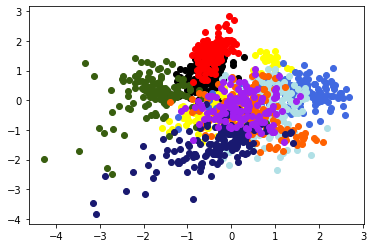

In [31]:
#(e) 2D scatter plot ( z 1 ,z 2 ) by computing the posterior mean of each point p ( z|x )

#Calculate the expectation of z|x
def Expect_z_x(F, Psi, x):
    Psi_inv= np.linalg.pinv(Psi)
    return np.dot(np.linalg.pinv((np.identity(H) + np.dot(np.dot(F.T,Psi_inv), F))), np.dot(np.dot(F.T, Psi_inv), x))

Z = np.zeros((test_set.shape[1], 2))
for i in range(test_set.shape[1]):
    Z[i, :] = Expect_z_x(F, Psi, test_set[:, i])


    
colors = ['#000000', '#FFFF00', '#4169E1', '#B0E0E6', '#385E0F', '#FF6100', '#FF0000', '#191970', '#A020F0', '#7FFF00']
for i in range(9):
    plt.scatter(Z[target_test == i,0], Z[target_test == i, 1], c = colors[i])
plt.show()

In [32]:
#(h) Show the sample data with the smallest, median and largest posterior values on both z 1 and z 2
Z = np.zeros((train_set.shape[1], 2))
for i in range(train_set.shape[1]):
    Z[i, :] = Expect_z_x(F, Psi, train_set[:, i])
z1_smallest = np.min(Z[:, 0])
z1_median = np.median(Z[:, 0])
z1_largest = np.max(Z[:, 0])
z2_smallest = np.min(Z[:, 1])
z2_median = np.median(Z[:, 1])
z2_largest = np.max(Z[:, 1])
print("smallest z1 : ", z1_smallest)
print("median z1 : ", z1_median)
print("largest z1 : ", z1_largest)
print("smallest z2 : ", z2_smallest)
print("median z2 : ", z2_median)
print("largest z2 : ", z2_largest)

smallest z1 :  -2.93775142535656
median z1 :  -0.06370229451057474
largest z1 :  2.6804929829649584
smallest z2 :  -3.432548145603621
median z2 :  0.06312120155376984
largest z2 :  2.46841591233684
